In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# https://tex2e.github.io/blog/crypto/elliptic-curve-scala-mul　より

# 拡張ユークリッドの互除法
def xgcd(a, b):
    x0, y0, x1, y1 = 1, 0, 0, 1
    while b != 0:
        q, a, b = a // b, b, a % b
        x0, x1 = x1, x0 - q * x1
        y0, y1 = y1, y0 - q * y1
    return a, x0, y0

# 有限体の乗法逆元（モジュラ逆数）を求める
def modinv(a, m):
    g, x, y = xgcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

# 有限体 (ただしpは素数)
def GF(p):

    class Fp:
        def __init__(self, val):
            self.val = int(val) % Fp.p
        def __neg__(self):
            return Fp(-self.val)
        def __add__(self, other):
            return Fp(self.val + int(other))
        def __sub__(self, other):
            return Fp(self.val - int(other))
        def __mul__(self, other):
            return Fp(self.val * int(other))
        def __pow__(self, e):
            return Fp(pow(self.val, int(e), Fp.p))
        def __floordiv__(self, other):
            return self * modinv(other.val, Fp.p)
        def __mod__(self, m):
            return self.val % int(m)
        def __eq__(self, other):
            return self.val == other.val
        def __repr__(self):
            return str(self.val)
        def __int__(self):
            return self.val

        __radd__ = __add__
        __rsub__ = __sub__
        __rmul__ = __mul__
        __rfloordiv__ = __floordiv__

    Fp.p = p
    return Fp


# 有限体上の楕円曲線
class EllipticCurveOverFp:
    """
    y**2 = x**3 + a*x + b (mod p)
    """

    def __init__(self, a, b, p):
        self.p = p
        self.Fp = GF(p)
        self.a = self.Fp(a)
        self.b = self.Fp(b)


# 楕円曲線の点
class PointOverEC:

    def __init__(self, curve, x, y, infinity=False):
        self.curve = curve
        self.Fp = curve.Fp
        self.x = x
        self.y = y
        self.infinity = infinity
        if self.Fp(y**2) != self.Fp(x**3 + curve.a * x + curve.b):
            raise Exception('(%d, %d) is not on curve!' % (x, y))

    @staticmethod
    def get_infinity():
        dummy_curve = EllipticCurveOverFp(0,0,1)
        return PointOverEC(curve=dummy_curve, x=0, y=0, infinity=True)

    def is_infinity(self):
        return self.infinity

    def get_point(self):
        return self.Fp(self.x), self.Fp(self.y)

    def __str__(self):
        if self.infinity:
            return "(∞,∞)"
        return "({},{})".format(self.x, self.y)

    # 楕円曲線上の点の加算
    def __add__(self, other):
        x1, y1 = self.get_point()
        x2, y2 = other.get_point()

        if x1 == x2 and y2 == -y1:
            return PointOverEC.get_infinity()
        if self.is_infinity():
            return other
        if other.is_infinity():
            return self

        if x1 == x2 and y1 == y2:
            l = (3 * x1**2 + self.curve.a) // (2 * y1)
        else:
            l = (y2 - y1) // (x2 - x1)

        x3 = l**2 - x1 - x2
        y3 = l * (x1 - x3) - y1

        return PointOverEC(self.curve, x3, y3)

    # 楕円曲線上の点のスカラー倍算
    def __rmul__(self, n):
        # O(log2(n))
        tmp = self
        point = PointOverEC.get_infinity()
        while n > 0:
            if n & 1 == 1:
                point += tmp
            n >>= 1
            tmp += tmp
        return point


In [3]:
curve = EllipticCurveOverFp(a=1, b=6, p=71)
a = PointOverEC(curve, x=1, y=24)

# 点の位数を求める（無限遠点になるまでスカラー倍する）
cycle = []
for k in range(1, 100):
    ka = k * a
    cycle.append((k, (ka.x,ka.y)))
    if ka.is_infinity():
        break
print(cycle)

[(1, (1, 24)), (2, (34, 62)), (3, (37, 12)), (4, (41, 13)), (5, (49, 46)), (6, (45, 15)), (7, (33, 60)), (8, (66, 36)), (9, (8, 61)), (10, (3, 6)), (11, (6, 21)), (12, (53, 64)), (13, (47, 28)), (14, (32, 69)), (15, (67, 68)), (16, (35, 48)), (17, (7, 1)), (18, (56, 33)), (19, (39, 24)), (20, (31, 47)), (21, (16, 0)), (22, (31, 24)), (23, (39, 47)), (24, (56, 38)), (25, (7, 70)), (26, (35, 23)), (27, (67, 3)), (28, (32, 2)), (29, (47, 43)), (30, (53, 7)), (31, (6, 50)), (32, (3, 65)), (33, (8, 10)), (34, (66, 35)), (35, (33, 11)), (36, (45, 56)), (37, (49, 25)), (38, (41, 58)), (39, (37, 59)), (40, (34, 9)), (41, (1, 47)), (42, (0, 0))]


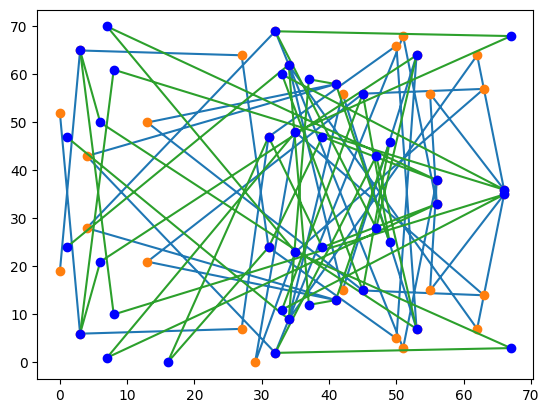

In [4]:
p = 71
a = PointOverEC(curve, x=0, y=19)

k = 1
ka = k * a
xcord = []
ycord = []

while not ka.is_infinity():
    xcord.append(ka.x)
    ycord.append(ka.y)
    k += 1
    ka = k * a

# print(np.array(xcord).astype(int))
# print(np.array(ycord).astype(int))
plt.plot(np.array(xcord).astype(int), np.array(ycord).astype(int))
plt.plot(np.array(xcord).astype(int), np.array(ycord).astype(int), 'o')

a = PointOverEC(curve, x=1, y=24)

k = 1
ka = k * a
xcord = []
ycord = []

while not ka.is_infinity():
    xcord.append(ka.x)
    ycord.append(ka.y)
    k += 1
    ka = k * a

plt.plot(np.array(xcord).astype(int), np.array(ycord).astype(int))
plt.plot(np.array(xcord).astype(int), np.array(ycord).astype(int), 'bo')

plt.show()

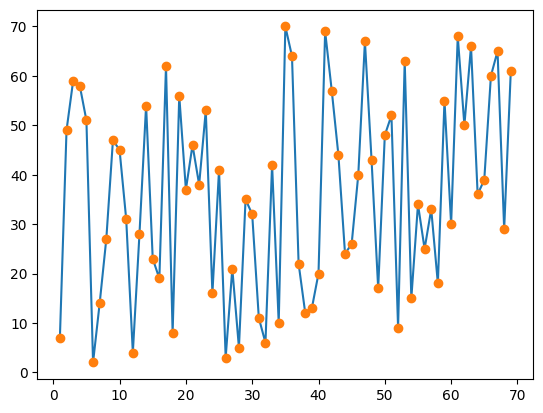

In [5]:
p = 71
k = 1
a = 7
xcord = []
ycord = []

while a**k % p != 1:
    xcord.append(k)
    ycord.append(a**k % p)
    k += 1

# print(ycord)
plt.plot(np.array(xcord).astype(int), np.array(ycord).astype(int))
plt.plot(np.array(xcord).astype(int), np.array(ycord).astype(int), 'o')

plt.show()